In [8]:
import pandas as pd
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string

In [9]:
# Load the saved data
df = pd.read_csv('../data/reddit_posts.csv')

# Combine title and selftext into a single text field
df['selftext'] = df['selftext'].fillna('')
df['text'] = df['title'] + ' ' + df['selftext']

# Drop rows where text is empty after combining
df = df[df['text'].str.strip().astype(bool)]

# Reset index
df.reset_index(drop=True, inplace=True)

# Preview result
df[['subreddit', 'text']].head()

,subreddit,text
0,science,A new study across 11 African reserves found t...
1,science,Low-calorie diets might increase risk of depre...
2,science,People around the world are more likely to fav...
3,science,Self-perceived physical attractiveness linked ...
4,science,Efficient mRNA delivery to resting T cells to ...


In [10]:
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

def clean_text(
    text,
    remove_urls=True,
    remove_markdown=True,
    remove_non_ascii=True,
    remove_punctuation=True,
    remove_stopwords=True,
    lemmatize=True
):
    if not isinstance(text, str):
        return ""
    
    # Step 1: Lowercase
    text = text.lower()

    # Remove URLs
    if remove_urls:
        text = re.sub(r"http\S+|www\.\S+", "", text)

    # Remove markdown
    if remove_markdown:
        text = re.sub(r"\[.*?\]\(.*?\)", "", text)

    # Remove non-ascii
    if remove_non_ascii:
        text = text.encode("ascii", "ignore").decode("ascii")

    # Remove punctuation
    if remove_punctuation:
        text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenize
    doc = nlp(text)
    tokens = [token.text for token in doc]

    # Remove stopwords
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words and t.strip() != ""]

    # Lemmatize
    if lemmatize:
        tokens = [token.lemma_ for token in nlp(" ".join(tokens))]

    return " ".join(tokens)

# Apply the function to a DataFrame
df['clean_text'] = df['text'].apply(clean_text)

# Preview cleaned text
df[['subreddit', 'clean_text']].head()

,subreddit,clean_text
0,science,new study across 11 african reserve find dehor...
1,science,lowcalorie diet might increase risk depression...
2,science,people around world likely favor dominant auth...
3,science,selfperceived physical attractiveness link str...
4,science,efficient mrna delivery rest cell reverse hiv ...


In [12]:
def preprocess_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    text = text.lower()
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and
           token.lemma_ not in STOP_WORDS and
           len(token.lemma_) > 2
    ]
    return " ".join(tokens)

df["processed_text"] = df["clean_text"].apply(preprocess_text)
df[["subreddit", "processed_text"]].head()

,subreddit,processed_text
0,science,new study african reserve find dehorn rhino cu...
1,science,lowcalorie diet increase risk depression overw...
2,science,people world likely favor dominant authoritari...
3,science,selfperceived physical attractiveness link str...
4,science,efficient mrna delivery rest cell reverse hiv ...


In [13]:
# Save processed dataset for modeling
df.to_csv('../data/reddit_preprocessed.csv', index=False)

In [14]:
# Word count per post
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))

# Average word count by subreddit
avg_lengths = df.groupby('subreddit')['word_count'].mean()
print("Average word count per post:")
print(avg_lengths)

# Most common words overall

all_words = ' '.join(df['processed_text']).split()
common_words = Counter(all_words).most_common(20)
print("\nTop 20 words:")
for word, count in common_words:
    print(f"{word}: {count}")

Average word count per post:
subreddit
science       17.358090
technology     8.643819
Name: word_count, dtype: float64

Top 20 words:
new: 255
study: 249
find: 195
use: 133
people: 109
risk: 82
researcher: 82
brain: 72
time: 70
scientist: 69
trump: 69
high: 69
research: 68
human: 67
age: 67
health: 64
year: 58
link: 57
cancer: 56
help: 55


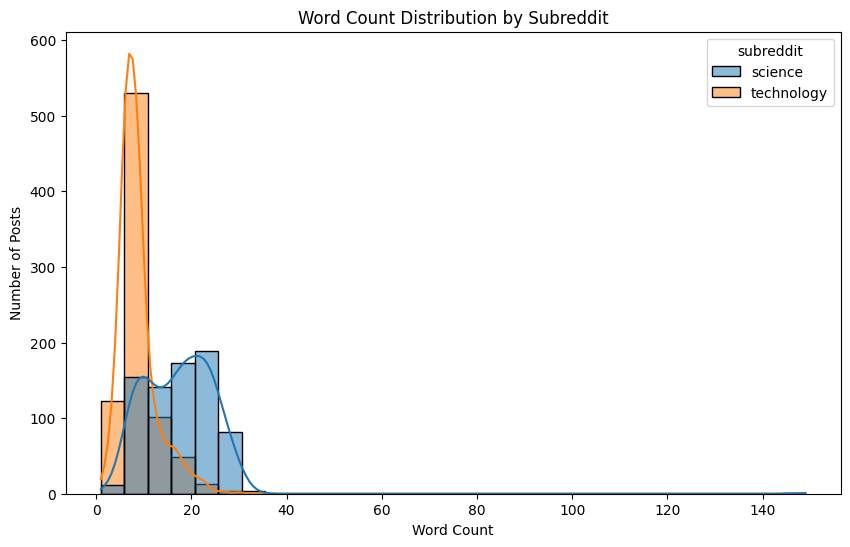

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', hue='subreddit', bins=30, kde=True)
plt.title('Word Count Distribution by Subreddit')
plt.xlabel('Word Count')
plt.ylabel('Number of Posts')
plt.show()

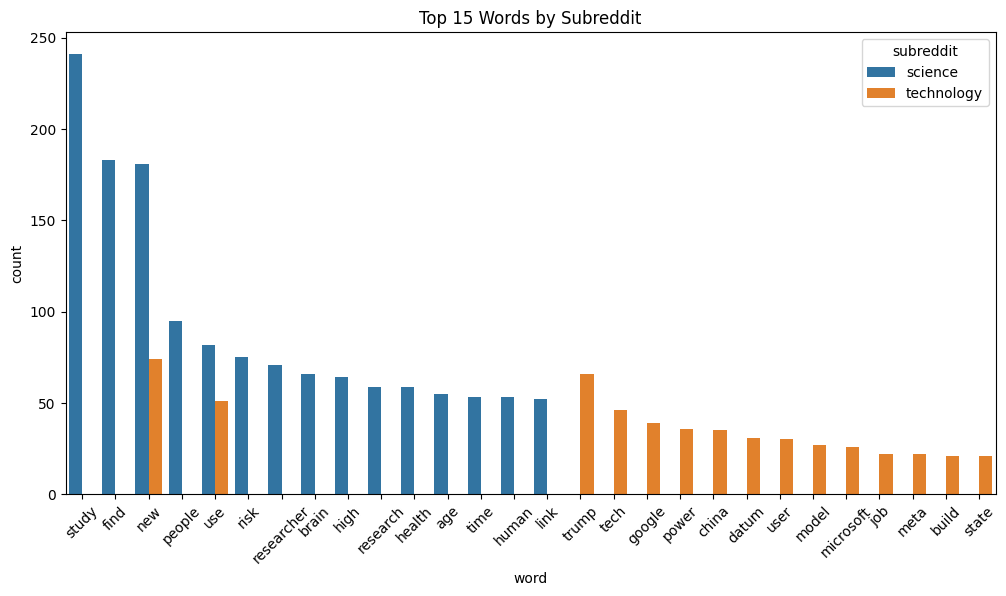

In [16]:
def top_words_by_group(group_df, n=15):
    words = ' '.join(group_df['processed_text']).split()
    return Counter(words).most_common(n)

# Get top words for each subreddit
science_top = top_words_by_group(df[df['subreddit'] == 'science'])
tech_top = top_words_by_group(df[df['subreddit'] == 'technology'])

# Turn into DataFrame for plotting
science_df = pd.DataFrame(science_top, columns=['word', 'count'])
science_df['subreddit'] = 'science'

tech_df = pd.DataFrame(tech_top, columns=['word', 'count'])
tech_df['subreddit'] = 'technology'

top_words_df = pd.concat([science_df, tech_df])

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_words_df, x='word', y='count', hue='subreddit')
plt.title('Top 15 Words by Subreddit')
plt.xticks(rotation=45)
plt.show()

In [17]:
# Generate text for each group
science_text = ' '.join(df[df['subreddit'] == 'science']['processed_text'])
tech_text = ' '.join(df[df['subreddit'] == 'technology']['processed_text'])

# Set up WordCloud config
wc = WordCloud(width=800, height=400, background_color='white', max_words=100)

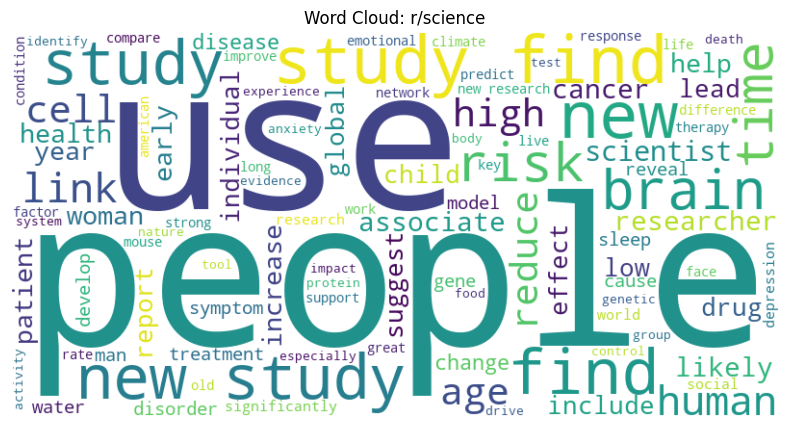

In [18]:
# Create and show science word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc.generate(science_text), interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: r/science')
plt.show()

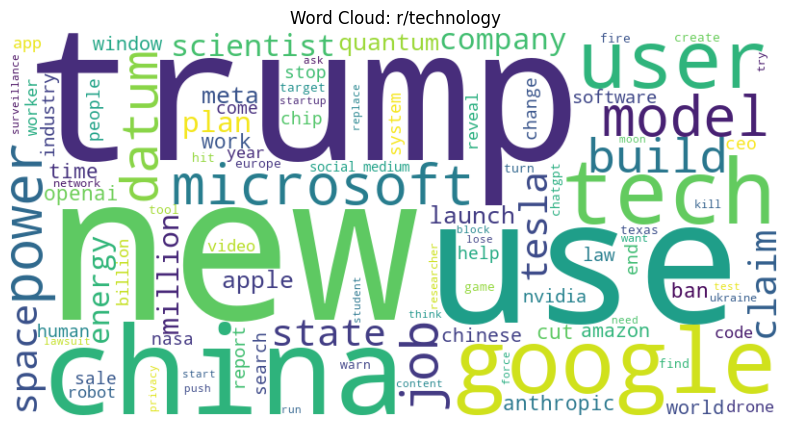

In [19]:
# Create and show technology word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc.generate(tech_text), interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: r/technology')
plt.show()